# Calculating Magnitudes for a user-provided SED in Auxtel

- adaptation of notebooks from https://github.com/lsst/rubin_sim_notebooks/tree/main/photometry


This notebook provides an example of calculating the expected AB magnitude in each filter for a user-provided spectral energy distribution (SED) with Rubin Observatory.

Many example SEDs can be found in the `sims_sed_library` (downloadable from NCSA as a [gzipped tar file](https://lsst.ncsa.illinois.edu/sim-data/sed_library/seds_170124.tar.gz)). This file has additional documentation in [confluence](https://confluence.lsstcorp.org/display/SIM/SED+%28Spectral+Energy+Density%29+models+in+the+Catalogs+Simulation+Framework), but includes Kurucz model spectra for main sequence stars, MLT spectra, white dwarf spectra, a range of asteroid spectral types, and various galaxy spectral templates.

This example will use a Kurucz model appropriate for our Sun (`kurucz_sun`) which has been copied into the photometry directory of the [rubin_sim_notebooks](https://github.com/lsst/rubin_sim_notebooks) repository.

The expected format of this file (or any other spectra you want to use) is two columns, the first containing wavelength in nanometers and the second containing either F$_\lambda$ (in ergs/cm$^2$/s/nm) or F$_\nu$ (in Janksy). Our example `kurucz_sun` contains wavelength(nm) / F$_\lambda$(ergs/cm$^2$/s/nm).


Adaptation from original rubinsim_notebooks for auxtel photometry

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creatiion date : 2024-01-02
- update : 2024-01-03
- update : 2024-03-30


In [1]:
# Import some generally useful packages

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
# Import the primary photometry classes from rubin_sim.photUtils
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data.data_sets import  get_data_dir

## Read the throughput curves ##

The throughput curves are currently downloaded as part of the `rs_download_data` script, and stored in `$RUBIN_SIM_DATA_DIR`. The default value for `$RUBIN_SIM_DATA_DIR` is `$HOME/rubin_sim_data`. 

In [3]:
fdir = get_data_dir()
print(fdir)

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubin_sim_data


In [4]:
!ls /Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubin_sim_data/throughputs/auxtel

LSST_SDSS_Filters_g.xlsx
LSST_SDSS_Filters_i.xlsx
LSST_SDSS_Filters_r.xlsx
LSST_SDSS_Filters_y.xlsx
LSST_SDSS_Filters_z.xlsx
auxtel_sdss_g.dat
auxtel_sdss_gp.dat
auxtel_sdss_i.dat
auxtel_sdss_ip.dat
auxtel_sdss_r.dat
auxtel_sdss_rp.dat
auxtel_sdss_u.dat
auxtel_sdss_up.dat
auxtel_sdss_yp.dat
auxtel_sdss_z.dat
auxtel_sdss_zp.dat
multispectra_holo4_003_HD142331_20230802_AuxTel_doGainsPTC_v3.0.3_throughput.txt


In [5]:
# Find the throughputs directory 
#fdir = os.getenv('RUBIN_SIM_DATA_DIR')
fdir = get_data_dir()
if fdir is None:  #environment variable not set
    fdir = os.path.join(os.getenv('HOME'), 'rubin_sim_data')

fdir = os.path.join(fdir, 'throughputs', 'auxtel')

!ls $fdir

LSST_SDSS_Filters_g.xlsx
LSST_SDSS_Filters_i.xlsx
LSST_SDSS_Filters_r.xlsx
LSST_SDSS_Filters_y.xlsx
LSST_SDSS_Filters_z.xlsx
auxtel_sdss_g.dat
auxtel_sdss_gp.dat
auxtel_sdss_i.dat
auxtel_sdss_ip.dat
auxtel_sdss_r.dat
auxtel_sdss_rp.dat
auxtel_sdss_u.dat
auxtel_sdss_up.dat
auxtel_sdss_yp.dat
auxtel_sdss_z.dat
auxtel_sdss_zp.dat
multispectra_holo4_003_HD142331_20230802_AuxTel_doGainsPTC_v3.0.3_throughput.txt


In [6]:
# Read the throughput curves
#filterlist = ['u', 'g', 'r', 'i', 'z']
filterlist = ['up', 'gp', 'rp', 'ip', 'zp','yp']

auxtel_sdss = {}
for f in filterlist:
    auxtel_sdss[f] = Bandpass()
    auxtel_sdss[f].read_throughput(os.path.join(fdir, f'auxtel_sdss_{f}.dat'))

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 10.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


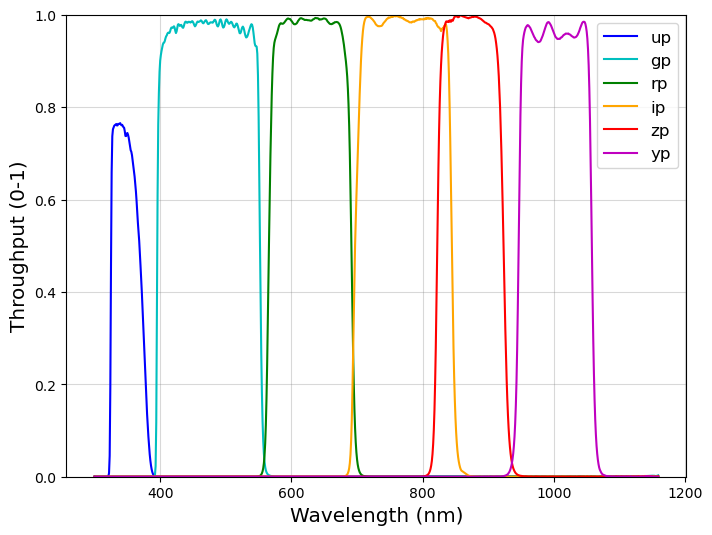

In [8]:
# Plot the curves .. see what we have. 
filtercolors = {'up':'b', 'gp':'c', 'rp':'g', 'ip':'orange', 'zp':'r', 'yp':'m'}

plt.figure(figsize=(8,6))
for f in filterlist:
    plt.plot(auxtel_sdss[f].wavelen, auxtel_sdss[f].sb, color=filtercolors[f], label=f)
plt.xlabel("Wavelength (nm)", fontsize='x-large')
plt.ylabel("Throughput (0-1)", fontsize='x-large')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, color='gray')
plt.legend(loc='upper right', fancybox=True, fontsize='large')

## Read the SED ##

We must also read the `kurucz_sun` spectrum into a Sed object. Because `kurucz_sun` contains $\lambda$ / F$_\lambda$, we use the Sed method `readSED_flambda`. If it had been a file containing $\lambda$ / F$_\nu$, we would use the `readSED_fnu` method instead.

In [9]:
# Read the SED

sun = Sed()
sun.read_sed_flambda('kurucz_sun')

Text(0, 0.5, '$\\lambda F_\\lambda$ (ergs/cm$^2$/s)')

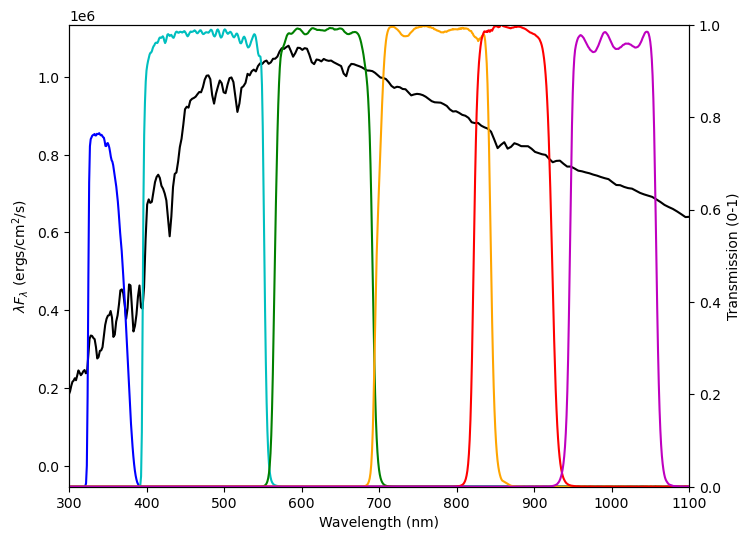

In [10]:
# Let's see what the SED and throughputs look like together
fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(1,1,1)
ax2 = ax1.twinx()
for f in filterlist:
    ax2.plot(auxtel_sdss[f].wavelen, auxtel_sdss[f].sb, color=filtercolors[f])
ax1.plot(sun.wavelen, sun.wavelen*sun.flambda, color='k')
plt.xlim(300, 1100)
ax1.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('Transmission (0-1)')
ax2.set_ylim(0, 1)
ax1.set_ylabel('$\lambda F_\lambda$ (ergs/cm$^2$/s)')

## Calculate the magnitudes ##

Calculating the AB magnitudes. This is simple, using the 'calcMag' method on Sed.

These are the magnitudes 'above the atmosphere' and *as would be reported by Rubin*. Note that these magnitudes *do* include some of the absorption effects of the atmosphere; e.g. the shape of the throughput curves includes the effects of a standard atmosphere. However, the grey-scale extinction due to the atmosphere (or clouds) is not included; this is what is generally meant by 'above the atmosphere' AB magnitudes.

In [11]:
# Calculate expected AB magnitudes. 

mags = {}
for f in filterlist:
    mags[f] = sun.calc_mag(auxtel_sdss[f])

# Make a dataframe just to get a nice output cell.
pd.DataFrame(mags, index=['Sun']).T

,Sun
up,-25.141096
gp,-26.456867
rp,-26.946399
ip,-27.048162
zp,-27.055962
yp,-27.065052


The sun is pretty bright. 

However, let's suppose we had a star which had a spectrum like the Sun, but was further away. Say we know that it should have an AB magnitude of r=20. 

We can scale the above SED to have the appropriate magnitude in r band, and then calculate the resulting AB magnitudes in the other bandpasses, using the 'calcFluxNorm' and 'multiplyFluxNorm' methods on Sed.

In [13]:
# Scale spectrum and recalculate magnitudes.

r = 20.0

flux_norm = sun.calc_flux_norm(r, auxtel_sdss['rp'])

sun.multiply_flux_norm(flux_norm)

mags = {}
for f in filterlist:
    mags[f] = sun.calc_mag(auxtel_sdss[f])
    
pd.DataFrame(mags, index=['Distant Sun']).T

,Distant Sun
up,21.805303
gp,20.489531
rp,20.000000
ip,19.898237
zp,19.890437
yp,19.881347


There are other methods on Sed which can be useful - for example, adding dust extinction or redshifting an object. More information is available on these methods in the [class documentation](https://github.com/lsst/rubin_sim/blob/master/rubin_sim/photUtils/Sed.py).

### Non-standard uses ###

The examples in this section may come up in some more advanced uses. 

#### Calculating magnitudes in multiple bandpasses more quickly #### 

In some applications, calculating magnitudes in all bandpasses with as much speed as possible is important. In the standard usage (demonstrated above), the calculation makes copies of some of the arrays in order to avoid permanently modifying the originals. There are several checks that are done as well, to make sure that the wavelength ranges are as intended. Here are some varying approaches.

In [14]:
sun = Sed()
sun.read_sed_flambda('kurucz_sun')

filterlist = ['up', 'gp', 'rp', 'ip', 'zp','yp']

auxtel_sdss = {}
for f in filterlist:
    auxtel_sdss[f] = Bandpass()
    auxtel_sdss[f].read_throughput(os.path.join(fdir, f'auxtel_sdss_{f}.dat'))

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 10.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


In [15]:
%%timeit 

# Standard calculation
mags = []
for f in filterlist:
    mags.append(sun.calc_mag(auxtel_sdss[f]))

102 µs ± 1.07 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [16]:
%%timeit 

# Slightly modified calculation
# Resample sun onto the same wavelength grid as the filtercurves once 
sun.resample_sed(wavelen_match = auxtel_sdss['rp'].wavelen)
sun.flambda_tofnu()
mags = []
for f in filterlist:
    #print(f)
    mags.append(sun.calc_mag(auxtel_sdss[f]))

74.7 µs ± 769 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [17]:
# Generate the phiArray for calculating the multi-band magnitudes - the fast option below
phiArray, wavelenstep = sun.setup_phi_array([auxtel_sdss[f] for f in filterlist])

In [19]:
%%timeit

# More modified version

# Resample the sun onto the desired wavelength (permanently)
sun.resample_sed(wavelen_match = auxtel_sdss['rp'].wavelen)
# Calculate Fnu as well as Flambda
sun.flambda_tofnu()

allmags = sun.many_mag_calc(phiArray, wavelenstep)

16.5 µs ± 353 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


#### Wavelength ranges non-overlapping #### 

Sometimes you will get an error message saying the wavelength ranges do not overlap (for the SED and the filter curves), which will result in NaNs in the resulting magnitudes. 

The problem here is that by default, we read in the bandpasses with a standard wavelength range and grid, same as they are stored on disk. This lets those 'faster' magnitude calculations above work with a single resampling of the SED. On the other hand, if you only are interested in z band and have a SED which cuts off at 400 nm, this message may not make that much sense. 

In [20]:
sun = Sed()
sun.read_sed_flambda('kurucz_sun')

filterlist = ['up', 'gp', 'rp', 'ip', 'zp']

auxtel_sdss = {}
for f in filterlist:
    auxtel_sdss[f] = Bandpass()
    auxtel_sdss[f].read_throughput(os.path.join(fdir, f'auxtel_sdss_{f}.dat'))
    
sun.resample_sed(wavelen_match = auxtel_sdss['zp'].wavelen)
    
sun.wavelen[0], sun.wavelen[100], sun.wavelen.max(), auxtel_sdss['rp'].wavelen.min(), auxtel_sdss['rp'].wavelen.max()

(300.0, 400.0, 1159.0, 300.0, 1159.0)

In [21]:
# Example: 
short_sun = Sed(wavelen=sun.wavelen[100:], flambda=sun.flambda[100:])

print('Original sun, z band', sun.calc_mag(auxtel_sdss['zp']).round(2))
print('short sun, z band', short_sun.calc_mag(auxtel_sdss['zp']))

Original sun, z band -27.06
short sun, z band nan


/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/sed.py:804: UserWarning: There is an area of non-overlap between desired wavelength range  (300.00 to 1159.00)and sed FromArray (400.00 to 1159.00)
  warnings.warn(


Solutions to this problem include: the user explicitly setting the flambda values to 0 (or some other desired value) outside the original wavelength range, and then calculating the magnitude, or explicitly defining the wavelength range for the filter to only cover the range of wavelengths represented in the SED. Obviously in either case, you should be sure that you are not missing flux that should have been included. 

In [22]:
# Fill in values: 
short_sun = Sed(wavelen=sun.wavelen[100:], flambda=sun.flambda[100:])

# Extend at short wavelengths 
ext = np.where(auxtel_sdss['zp'].wavelen < short_sun.wavelen.min())
wavelen_extend = auxtel_sdss['zp'].wavelen[ext]
flambda_extend = np.zeros(len(wavelen_extend), float)

short_sun.wavelen = np.concatenate([wavelen_extend, short_sun.wavelen])
short_sun.flambda = np.concatenate([flambda_extend, short_sun.flambda])

# Extend at long wavelengths 
ext = np.where(auxtel_sdss['zp'].wavelen > short_sun.wavelen.max())
wavelen_extend = auxtel_sdss['zp'].wavelen[ext]
flambda_extend = np.zeros(len(wavelen_extend), float)

short_sun.wavelen = np.concatenate([short_sun.wavelen, wavelen_extend])
short_sun.flambda = np.concatenate([short_sun.flambda, flambda_extend])

print('Original sun, zp band', sun.calc_mag(auxtel_sdss['zp']).round(2))
print('short sun, zp band', short_sun.calc_mag(auxtel_sdss['zp']).round(2))

Original sun, zp band -27.06
short sun, zp band -27.06


In [23]:
# Cut wavelength range for filter curve
short_sun = Sed(wavelen=sun.wavelen[100:], flambda=sun.flambda[100:])

z_short = Bandpass()
z_short.read_throughput(os.path.join(fdir, f'auxtel_sdss_{f}.dat'))
z_short.resample_bandpass(wavelen_min=short_sun.wavelen.min(), wavelen_max=short_sun.wavelen.max(),
                         wavelen_step=short_sun.wavelen[1]-short_sun.wavelen[0])

print('Original z band', sun.calc_mag(auxtel_sdss['zp']).round(2))
print('short z band', short_sun.calc_mag(z_short).round(2))

Original z band -27.06
short z band -27.06
